In [1]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from scipy import ndimage
# from scipy.optimize import curve_fit
from scipy.optimize import minimize
# from scipy.stats import median_absolute_deviation
import xarray as xr

import debrisglobal.globaldebris_input as debris_prms

In [2]:
data_source = 'regional'
# data_source = 'individual_glaciers'

# rois = ['11','12','13','14','15']
rois = ['13']

output_fp_noretreat = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/Output/cal_opt3/_4debrispaper/_noretreat/'
output_fp_wbnds = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/Output/cal_opt3/_4debrispaper/_bnds/'

roi_mbobs_dict = {'11': [-0.91, 0.70],
                  '12': [-0.88, 0.57],
                  '13': [-0.19, 0.15],
                  '14': [-0.11, 0.15],
                  '15': [-0.44, 0.15]}

In [3]:
def process_reg_dif(output_fp_roi):
    mbclim_fns = []
    for i in os.listdir(output_fp_roi):
        if i.endswith('_mbclim_data.csv'):
            mbclim_fns.append(i)
    
    mbclim_fns = sorted(mbclim_fns)
    rgiids_wdebris = ['RGI60-' + x.split('_')[0].split('.')[0].zfill(2) + '.' + x.split('_')[0].split('.')[1] 
                      for x in mbclim_fns]
    rgino_str_wdebris = [x.split('-')[1] for x in rgiids_wdebris]
    
    main_glac_rgi_wdebris = debris_prms.selectglaciersrgitable(glac_no=rgino_str_wdebris)
    main_glac_rgi_wdebris['mbclim_fn'] = mbclim_fns
    
    print('ROI', roi, 'has', len(rgiids_wdebris), 'dc glaciers')
    
    mbclim_df_all = None
    reg_dc_area = 0
    for nglac, mbclim_fn in enumerate(mbclim_fns):
        mbclim_df = pd.read_csv(output_fp_roi + main_glac_rgi_wdebris.loc[nglac,'mbclim_fn'])
        mbclim_df['elev'] = [int(np.round(x,0)) for x in mbclim_df.elev.values]
        
        if mbclim_df_all is None:
            mbclim_df_all = mbclim_df
        else:
            mbclim_df_all = pd.concat([mbclim_df_all, mbclim_df], axis=0)
    mbclim_df_all.reset_index(inplace=True, drop=True)
    
    elev_min = mbclim_df_all.elev.min()
    elev_max = mbclim_df_all.elev.max()
    elev_bins_all = np.arange(elev_min, elev_max+5, 10)
    reg_mbclim_df = pd.DataFrame(np.zeros((len(elev_bins_all), len(mbclim_df.columns))), columns=mbclim_df.columns)
    for nelev, elev in enumerate(elev_bins_all):
        try:
            elev_idx = np.where(mbclim_df_all.elev.values == elev)[0]
        except:
            elev_idx = []
        
        if len(elev_idx) > 0:
            mbclim_df_all_subset = mbclim_df_all[mbclim_df_all.elev == elev]
            reg_subset_area = mbclim_df_all_subset.area.sum()
            reg_subset_mf = (mbclim_df_all_subset.mf * mbclim_df_all_subset.area).sum() / reg_subset_area
            reg_subset_mbclim_wdebris = ((mbclim_df_all_subset.mbclim_mwea_wdebris * mbclim_df_all_subset.area).sum() 
                                         / reg_subset_area)
            reg_subset_mbclim_nodebris = ((mbclim_df_all_subset.mbclim_mwea_nodebris * mbclim_df_all_subset.area).sum() 
                                          / reg_subset_area)
            reg_frontalablation = ((mbclim_df_all_subset.frontalablation * mbclim_df_all_subset.area).sum() 
                                   / reg_subset_area)
            reg_mbclim_df.loc[nelev,:] = [elev, reg_subset_area, reg_subset_mf, reg_subset_mbclim_wdebris, 
                                          reg_subset_mbclim_nodebris, reg_frontalablation]
            
    # ===== REGIONAL COMPUTATIONS ======
    reg_mbclim_wdebris_DC = (reg_mbclim_df.mbclim_mwea_wdebris * reg_mbclim_df.area).sum() / reg_mbclim_df.area.sum()
    reg_mbclim_nodebris_DC = (reg_mbclim_df.mbclim_mwea_nodebris * reg_mbclim_df.area).sum() / reg_mbclim_df.area.sum()

    main_glac_rgi_all = debris_prms.selectglaciersrgitable(rgi_regionsO1=[int(roi)], rgi_regionsO2='all',
                                                           rgi_glac_number='all')
    rgiids_all = list(main_glac_rgi_all.RGIId.values)
    rgiids_missing = set(rgiids_all) - set(rgiids_wdebris)
    rgino_str_missing = [x.split('-')[1] for x in rgiids_missing]
    main_glac_rgi_missing = debris_prms.selectglaciersrgitable(glac_no=rgino_str_missing)
    
    print('Debris-covered area only:')
    print('  mbclim (debris): ' + str(np.round(reg_mbclim_wdebris_DC,2)) + ' mwea')
    print('  mbclim (clean): ' + str(np.round(reg_mbclim_nodebris_DC,2)) + ' mwea')
    print(str(np.round(main_glac_rgi_missing.Area.sum() / main_glac_rgi_all.Area.sum() * 100)) + '%')
    print(str(np.round(reg_mbclim_df.area.sum() / main_glac_rgi_all.Area.sum() * 100)) + '%')
    print('reg_mbclim_df area:', reg_mbclim_df.area.sum())
    print('regional area:', main_glac_rgi_all.Area.sum())
    
    reg_mb_all = roi_mbobs_dict[roi][0]
    print(reg_mbclim_wdebris_DC, reg_mbclim_df.area.sum(), reg_mb_all, main_glac_rgi_missing.Area.sum())

    reg_mb_wdebris = ((reg_mbclim_wdebris_DC * reg_mbclim_df.area.sum() + 
                       reg_mb_all * main_glac_rgi_missing.Area.sum()) 
                      / (reg_mbclim_df.area.sum() + main_glac_rgi_missing.Area.sum()))
    reg_mb_nodebris = ((reg_mbclim_nodebris_DC * reg_mbclim_df.area.sum() + 
                        reg_mb_all * main_glac_rgi_missing.Area.sum()) 
                       / (reg_mbclim_df.area.sum() + main_glac_rgi_missing.Area.sum()))

    print('reg_mb_wdebris:', np.round(reg_mb_wdebris,2))
    print('reg_mb_nodebris:', np.round(reg_mb_nodebris,2),'\n\n')

            
    # ===== Plot regional curves ======
    # Only plot mass balance of bins with glacier (otherwise get streaks to 0 that aren't real)
    elev_bins = reg_mbclim_df.elev.values
    bins_area = reg_mbclim_df.area.values
    glacier_debrismf = reg_mbclim_df.mf.values
    glac_bin_massbalclim_annual_mean_wdebris = reg_mbclim_df.mbclim_mwea_wdebris.values
    glac_bin_massbalclim_annual_mean_nodebris = reg_mbclim_df.mbclim_mwea_nodebris.values
    
    return (bins_area, elev_bins, glacier_debrismf, reg_mb_wdebris, reg_mb_nodebris,
            glac_bin_massbalclim_annual_mean_wdebris, glac_bin_massbalclim_annual_mean_nodebris)

In [4]:
# ===== REGIONAL MBCLIM PLOTS ====================================================================================
# PyGEM HH2015 calibration with and without debris
reg_output_cns = ['roi', 'area_km2', 'mb_obs_mwea', 'mb_obs_mwea_std', 'mb_mod_mwea', 'mb_mod_mwea_clean']
reg_output_df = pd.DataFrame(np.zeros((len(rois),len(reg_output_cns))), columns=reg_output_cns)
for nroi, roi in enumerate(rois):
    
    # ===== PROCESS THE NO RETREAT DATA ======
    output_fp_roi = output_fp_noretreat + data_source + '-mbclim/' + roi + '/'
    (bins_area, elev_bins, glacier_debrismf, reg_mb_wdebris, reg_mb_nodebris, 
     glac_bin_massbalclim_annual_mean_wdebris, glac_bin_massbalclim_annual_mean_nodebris) = (
        process_reg_dif(output_fp_roi))
    # ----- LOWER BOUND -----
    output_fp_roi_bndlow = output_fp_wbnds + 'bndlow_' + data_source + '-mbclim/' + roi + '/'
    (bins_area_bndlow, elev_bins_bndlow, glacier_debrismf_bndlow, reg_mb_wdebris_bndlow, reg_mb_nodebris_bndlow, 
     glac_bin_massbalclim_annual_mean_wdebris_bndlow, glac_bin_massbalclim_annual_mean_nodebris_bndlow) = (
        process_reg_dif(output_fp_roi_bndlow))
    # ----- UPPER BOUND -----
    output_fp_roi_bndhigh = output_fp_wbnds + 'bndhigh_' + data_source + '-mbclim/' + roi + '/'
    (bins_area_bndhigh, elev_bins_bndhigh, glacier_debrismf_bndhigh, reg_mb_wdebris_bndhigh, reg_mb_nodebris_bndhigh, 
     glac_bin_massbalclim_annual_mean_wdebris_bndhigh, glac_bin_massbalclim_annual_mean_nodebris_bndhigh) = (
        process_reg_dif(output_fp_roi_bndhigh))
    
    
    

8834 glaciers in region 13 are included in this model run: ['00067', '00080', '00093', '00137', '00175', '00188', '00190', '00198', '00199', '00200', '00202', '00203', '00209', '00210', '00211', '00217', '00218', '00221', '00222', '00223', '00226', '00228', '00233', '00235', '00236', '00240', '00246', '00248', '00250', '00299', '00335', '00345', '00358', '00386', '00391', '00394', '00399', '00400', '00402', '00413', '00420', '00500', '00502', '00503', '00505', '00507', '00508', '00515', '00516', '00517'] and more
This study is focusing on 8834 glaciers in region [13]
ROI 13 has 8834 dc glaciers
All glaciers within region(s) 13 are included in this model run.
This study is focusing on 54429 glaciers in region [13]
45595 glaciers in region 13 are included in this model run: ['00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', 

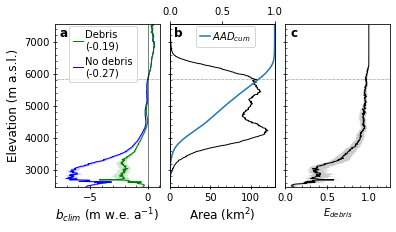

In [5]:
    bins_idx = np.where(bins_area > 0)[0]
    # ELA for each plot
    ela = elev_bins[np.abs(glac_bin_massbalclim_annual_mean_wdebris[bins_idx]).argmin()]
    
    fig, ax = plt.subplots(1, 3, squeeze=False, sharex=False, sharey=True, gridspec_kw={'wspace':0.1,'hspace':0})
    
    mbclim_wdebris_4fig = "{:.2f}".format(reg_mb_wdebris)
    mbclim_nodebris_4fig = "{:.2f}".format(reg_mb_nodebris)
    bins_idx = np.where(bins_area > 0)[0]
    
    # Dictionary (bclim_major, bclim_minor, elev_major, elev_minor, area_max)
    roi_mbclim_dict = {'11': [1000, 200, 5, 1, 10, 2, 28],
                       '12': [1000, 200, 2, 0.5, 5, 1, 13],
                       '13': [1000, 200, 5, 1, 50, 10, 130],
                       '14': [1000, 200, 5, 1, 50, 10, 180],
                       '15': [1000, 200, 5, 1, 25, 5, 95]}
    handlelength=1
    handletextpad=0.2
    
    # Mass balance gradients
    ax[0,0].plot(glac_bin_massbalclim_annual_mean_wdebris[bins_idx], elev_bins[bins_idx], 
                 color='g', linewidth=1, zorder=2, label='Debris\n(' + mbclim_wdebris_4fig + ')')
    ax[0,0].plot(glac_bin_massbalclim_annual_mean_nodebris[bins_idx], elev_bins[bins_idx], 
                 color='b', linewidth=1, zorder=1, label='No debris\n(' + mbclim_nodebris_4fig + ')')
    ax[0,0].axvline(x=0, color='k', linewidth=0.5)
    ax[0,0].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    # X label
    ax[0,0].set_xlabel('$b_{clim}$ (m w.e. a$\mathregular{^{-1}}$)', size=12)
#     ax[0,0].set_xlim(0,0.5)
    ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(roi_mbclim_dict[roi][2]))
    ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(roi_mbclim_dict[roi][3]))
    # Y label
    ax[0,0].set_ylabel('Elevation (m a.s.l.)', size=12)    
    ax[0,0].set_ylim(elev_bins.min() - 10, elev_bins.max() + 10)
    ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(roi_mbclim_dict[roi][0]))
    ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(roi_mbclim_dict[roi][1]))
    ax[0,0].legend(loc='upper left', bbox_to_anchor=(0.09, 1.02), handlelength=handlelength, handletextpad=handletextpad)
    # ---- bounds -----
    ax[0,0].fill_betweenx(elev_bins[bins_idx],
                          glac_bin_massbalclim_annual_mean_wdebris_bndlow[bins_idx], 
                          glac_bin_massbalclim_annual_mean_wdebris_bndhigh[bins_idx],
                          color='g', linewidth=0, zorder=3, alpha=0.2)
    ax[0,0].fill_betweenx(elev_bins[bins_idx],
                          glac_bin_massbalclim_annual_mean_nodebris_bndlow[bins_idx], 
                          glac_bin_massbalclim_annual_mean_nodebris_bndhigh[bins_idx],
                          color='b', linewidth=0, zorder=3, alpha=0.2)
    ax[0,0].tick_params(axis='both', which='major', direction='inout')
    ax[0,0].tick_params(axis='both', which='minor', direction='in') 

    # Glacier hypsometry
    ax[0,1].plot(bins_area[bins_idx], elev_bins[bins_idx], color='k', linewidth=1, zorder=1)
    ax[0,1].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    ax[0,1].set_xlabel('Area ($\mathregular{km^{2}}$)', size=12)
    ax[0,1].set_xlim(0,roi_mbclim_dict[roi][6])
    ax[0,1].xaxis.set_major_locator(plt.MultipleLocator(roi_mbclim_dict[roi][4]))
    ax[0,1].xaxis.set_minor_locator(plt.MultipleLocator(roi_mbclim_dict[roi][5]))
    ax[0,1].tick_params(axis='both', which='major', direction='inout')
    ax[0,1].tick_params(axis='both', which='minor', direction='in') 
    
    ax2 = ax[0,1].twiny()
    ax2.set_xlim(0,1)
    bins_area_cumsum = np.cumsum(bins_area)
    ax2.plot(bins_area_cumsum / bins_area.sum(), elev_bins, label='$AAD_{cum}$')
    ax2.legend(loc='upper left', bbox_to_anchor=(0.2, 1.02), handlelength=handlelength, handletextpad=handletextpad)

    # Debris thickness
    ax[0,2].plot(glacier_debrismf[bins_idx], elev_bins[bins_idx], color='k', linewidth=1, zorder=1)
    ax[0,2].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    ax[0,2].set_xlabel('$E_{debris}$')
    ax[0,2].set_xlim(0,1.25)
    ax[0,2].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[0,2].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
    # ---- bounds -----
    ax[0,2].fill_betweenx(elev_bins[bins_idx],
                          glacier_debrismf_bndlow[bins_idx], glacier_debrismf_bndhigh[bins_idx],
                          color='k', linewidth=0, zorder=3, alpha=0.2, label='')
    ax[0,2].tick_params(axis='both', which='major', direction='inout')
    ax[0,2].tick_params(axis='both', which='minor', direction='in') 
    
    # Labels
    ax[0,0].text(0.12, 0.98, 'a', size=12, fontweight='bold',
                horizontalalignment='right', verticalalignment='top', transform=ax[0,0].transAxes)
    ax[0,1].text(0.12, 0.98, 'b', size=12, fontweight='bold',
                horizontalalignment='right', verticalalignment='top', transform=ax[0,1].transAxes)
    ax[0,2].text(0.12, 0.98, 'c', size=12, fontweight='bold',
                horizontalalignment='right', verticalalignment='top', transform=ax[0,2].transAxes)

    # Save plot
    fig.set_size_inches(6, 3)
    fig_fp = output_fp_noretreat + 'debris_figs/'
    if not os.path.exists(fig_fp):
        os.makedirs(fig_fp)
    fig_fn = roi + '_mbgrad_debris.png'
    fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300, transparent=True)